# San Francisco's weather and the ocean

Our daily weather in SF is enourmously shaped by being on the west coast. 
All cities by oceans have coastal weather that is modulated by the temperatures of the nearby sea.
It rarely gets too hot, rarely gets too cold in SF because we always have the ocean to dampen extreme weather.

And we have Karl.... but why do we have Karl? SF fog is mostly present April-Sept.

From about April - Sept, we have seasonal winds (due to large scale pressure gradients) that blow from north to south along the west coast.
These winds along the coast drive our coastal upwelling, where surface water is pushed offshore and replaced by nutrient rich, cold, subsurface water.

Warm air can hold more water vapor. But if the air cools down, it can't hold as much water vapor and you get condensation (fog!).
So, the cold ocean waters cool the warm air and the result is fog.

But fog is one of those things that is easy to see, but hard to measure. Sort of like a rainbow. And it is so ephemeral sometimes, it will be so thick you can't see over by Richmond, and 500 m away in El Cerrito, there is none. We have satellites that measure visible radiation, so they see what we see (sort of), but they are Geostationary which are very very far away, so only recently have they been able to measure at the spatial resolution to start to see fog. But fog is white like clouds, so it can be hard to tell what is cloud and what is fog....

So, ocean temperatures can help us know when fog is likely, but they are more than that, they create the conditions that are good (or bad) for salmon, crab, clams, all our beautiful sealife and kelp forests.

# MUR SST

Multi-scale Ultra-high Resolution [(MUR) Sea Surface Temperature](https://podaac.jpl.nasa.gov/MEaSUREs-MUR) is produced by scientists at NASA's Jet Propulsion Laboratory who are part of an international science team - The Group for High Resolution Sea Surface Temperature [GHRSST](https://www.ghrsst.org/). MUR SST are from 2002 - present as global, daily, 4 km spatial resolution maps. This makes them great for looking at coastal dynamics where there is a lot of small-scale variablity.  MUR SST takes measurements from many different satellites and blends them all together to create one, daily, gap-free, map of SST.

There are a couple ways to access the data, but since the full dataset is about 4,000 GB, it is easier to just access what you need on the cloud rather than spend a few weeks downloading it.

If you don't need recent data, the easiest way to get [MUR SST is on AWS](https://registry.opendata.aws/mur/) where it is stored in a special cloud optimized format called Zarr. There are some tutorials that show you how to quickly access the data.

If you need more recent data, this notebook shows you how to access all the files, but it is slower because of the format the data is stored in.



In [327]:
#from urllib import request
#from http.cookiejar import CookieJar
import s3fs
import requests
from os.path import dirname, join
from io import StringIO
import xarray as xr
import earthaccess
import datetime
import os
import matplotlib.pyplot as plt
import tempfile
import time
import pandas as pd

#SET YOUR LOCATION HERE
center_lat, center_lon = 37.820220, -122.480255

# because accessing the data via the internet can be a little bit hiccup-y we
# have a special way to write the data that is more robust than just trying to 
# write it out. this is because the data isn't actually loaded to your computer
# until it is needed, for example when you want to save it locally.
def safe_write_netcdf(dataset, target_file):
    max_retries=4
    retries = 0
    success = False
    temp_file = None    
    while retries < max_retries and not success:
        try:
            # Create a temporary file in the same directory
            temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.nc').name
            # Write dataset to the temporary file first
            dataset.to_netcdf(temp_file)
            # Rename the temporary file to the target file
            os.rename(temp_file, target_file)
            print(f"Successfully written to {target_file}")
            success = True  # Mark success if no exception occurred
        except Exception as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}")
            time.sleep(2)  # Wait for 2 seconds before retrying
            if retries >= max_retries:
                print(f"Failed to write to {target_file} after {max_retries} attempts.")
                if os.path.exists(temp_file):
                    os.remove(temp_file)  # Clean up temporary file if writing fails
    dataset.close()

def get_buoy_data(station):

    file_list = ['https://www.ndbc.noaa.gov/data/historical/stdmet/'+station+'h2023.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/Jan/'+station+'12024.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/Feb/'+station+'22024.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/Mar/'+station+'32024.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/Apr/'+station+'42024.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/May/'+station+'52024.txt.gz',
         'https://www.ndbc.noaa.gov/data/stdmet/Jun/'+station+'62024.txt.gz']

    for index, fname in enumerate(file_list):
        df_buoy = pd.read_csv(fname, sep=r'\s+', header=0, parse_dates=True,na_values='MM')
        df_buoy = df_buoy.drop(index=0)
        df_buoy.rename(columns={"#YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}, inplace=True)
        df_buoy['Timestamp'] = pd.to_datetime(df_buoy[['year', 'month', 'day', 'hour', 'minute']])
        df_buoy = df_buoy.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'DPD', 'MWD', 'PRES', 'DEWP', 'VIS', 'TIDE']).drop(index=1)
        df_buoy = pd.DataFrame(df_buoy)
        columns_to_convert = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP']
        df_buoy[columns_to_convert] = df_buoy[columns_to_convert].apply(pd.to_numeric, errors='coerce')
        df_buoy.replace([99.00, 999], np.nan, inplace=True)
        df_buoy['time'] = pd.to_datetime(df_buoy['Timestamp']).astype('datetime64[ns]')
    
        if index==0:
            df = df_buoy
        else:
            df = pd.concat([df, df_buoy], ignore_index=True)
        print(index,len(df))

    start_date = '2023-06-21'
    end_date = '2024-06-20'
    # Filter the DataFrame for dates within the specified range
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    return df

In [3]:
earthaccess.login()

Enter your Earthdata Login username:  cgentemann
Enter your Earthdata password:  ········


In [12]:
def try_data(results):
    max_retries = 20  # Number of retry attempts
    ds = []
    file_handlers = earthaccess.open(results)
    for attempt in range(max_retries):
        try:
            ds =  xr.open_mfdataset(file_handlers, combine='by_coords')
            print("Successfully opened")
            break  # Exit the retry loop if successful
        except Exception as e:
            print("Failed to open",attempt)
            if attempt < max_retries - 1:  # Check if more attempts are available
               time.sleep(10)  # Wait for 5 seconds before retrying
            else:
               break
    return ds

In [14]:
year = 2023
date1 = datetime.date(year, 6, 21) 
date_str = date1.strftime('%Y-%m-%d')
date2 = datetime.date(year, 6, 21) + datetime.timedelta(days=364)
date_str2 = date2.strftime('%Y-%m-%d')
results = earthaccess.search_data(short_name='MUR-JPL-L4-GLOB-v4.1',temporal=(date_str, date_str2),version = '4.1')  #late run 12 hour lag

In [ ]:
#centered SF bay
ilen = len(results)
for incr in range(0,ilen,5):
    fname = 'c:/data/'+str(incr)+'.nc'
    if os.path.exists(fname):
        continue
    ds = try_data(results[incr:incr+5])
    subset = ds.sel(lat=slice(center_lat-.45,center_lat+.45),lon=slice(center_lon-.45,center_lon+.45))
    #subset = subset.load()
    subset = subset.drop_vars({'analysis_error','sea_ice_fraction','dt_1km_data','mask'})
    subset = subset.load()
    subset.to_netcdf(fname)
    print(ilen,incr,subset.time[0].data,subset.time[-1].data)

In [ ]:
ilen = len(results)
for incr in range(0,ilen,5):
    fname = 'c:/data_sf/'+str(incr)+'.nc'
    if os.path.exists(fname):
        continue
    ds = try_data(results[incr:incr+5])
    print(ilen,incr,'sf bay off',subset.time[0].data,subset.time[-1].data)
        #coast
    fname = 'c:/data_sf/'+str(incr)+'.nc'
    subset = ds.sel(lat=slice(center_lat-2,center_lat+2),lon=slice(center_lon-11.75,center_lon+1.2))
    subset = subset.drop_vars({'analysis_error','sea_ice_fraction','dt_1km_data','mask'})
    subset = subset.load()
    safe_write_netcdf(subset, fname)
    print(ilen,incr,'sf bay',subset.time[0].data,subset.time[-1].data)

In [221]:
ilen = len(results)
fpath = 'c:/data_sf/'
for incr in range(0,ilen,5):
    fname = fpath+str(incr)+'.nc'
    if os.path.exists(fname):
        ds = xr.open_dataset(fname)
        if incr==0:
            ds2 = ds
        else:
            ds2 = xr.concat([ds2,ds], dim="time")
fname = fpath + 'mur_sst_summer_sol.nc'
ds2.to_netcdf(fname)

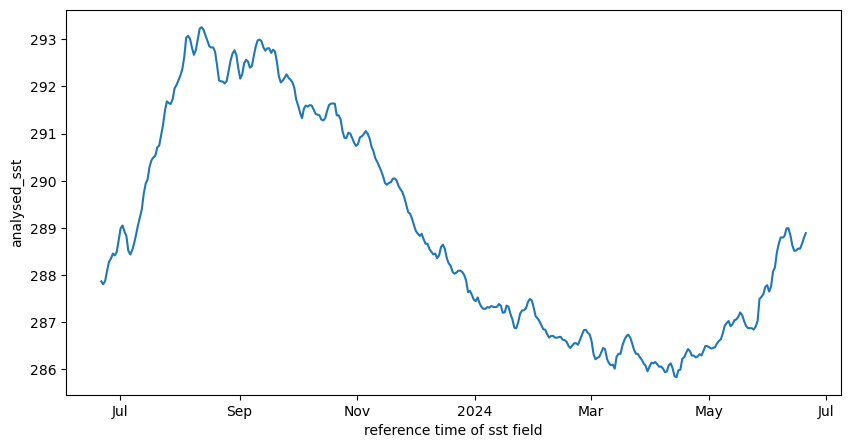

In [223]:
plt.figure(figsize=(10, 5))  # 10 inches wide, 6 inches tall
fpath = 'c:/data_sf/'
fname = fpath + 'mur_sst_summer_sol.nc'
ds2 = xr.open_dataset(fname)
ds2.close()
ts = ds2.mean(dim=['lat' ,'lon'],skipna=True)
ts.analysed_sst.plot()

The figure above shows the nice annual cycle in SST

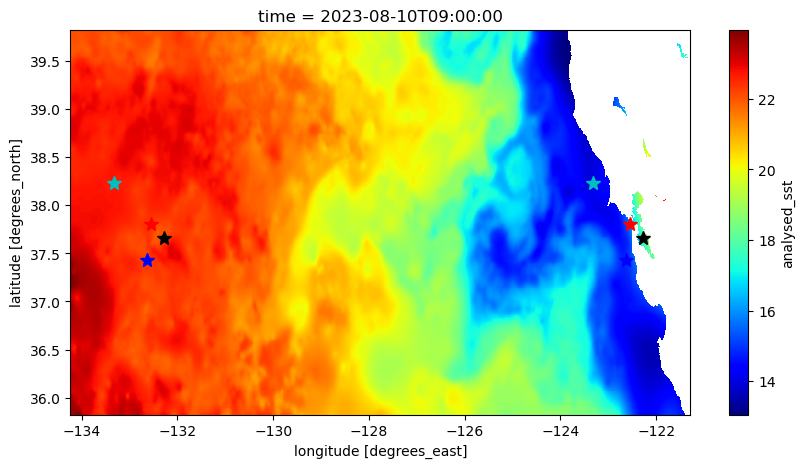

In [346]:
plt.figure(figsize=(10, 5))  # 10 inches wide, 6 inches tall
#ii,jj,cc = [165,192,10,168,120],[195,185,195,155,235],['r','k','m','b','c']
slat,slon = [37.802337,37.658968,37.430578, 38.235],[-122.546777,-122.272805, -122.628706, -123.317]
gtext = ['Golden Gate Bridge','Inner Bay','Half Moon Bay','Bodega Bay']
cc = ['r','k','b','c']
(ds2.analysed_sst[50,:,:]-273.15).plot(cmap='jet')
for i in range(len(slon)):
    plt.plot(slon[i],slat[i],'*',color=cc[i],markersize=10)
    plt.plot(slon[i]-10,slat[i],'*',color=cc[i],markersize=10)

This is SST in July --- when upwelling is very strong along the coast. You can see the cold water along the coast pushing out the warmer waters offshore.

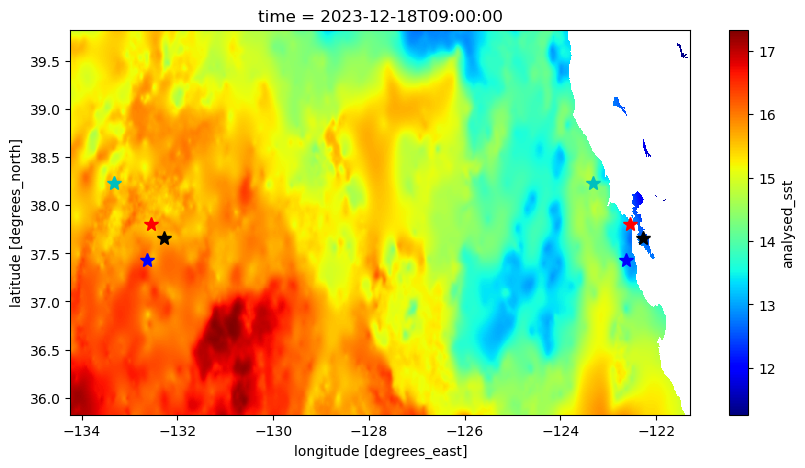

In [344]:
plt.figure(figsize=(10, 5))  # 10 inches wide, 6 inches tall
#ii,jj,cc = [165,192,10,168,120],[195,185,195,155,235],['r','k','m','b','c']
slat,slon = [37.802337,37.658968,37.430578, 38.235],[-122.546777,-122.272805, -122.628706, -123.317]
gtext = ['Golden Gate Bridge','Inner Bay','Half Moon Bay','Bodega Bay']
cc = ['r','k','b','c']
(ds2.analysed_sst[180,:,:]-273.15).plot(cmap='jet')
for i in range(len(slon)):
    plt.plot(slon[i],slat[i],'*',color=cc[i],markersize=10)
    plt.plot(slon[i]-10,slat[i],'*',color=cc[i],markersize=10)

This is SST in December when upwelling doesn't occur. The nearshore is still a bit cooler due to the California Current which moves cold northerly waters southward, but not nearly as cold as Summer.

Text(0.5, 0, 'Date')

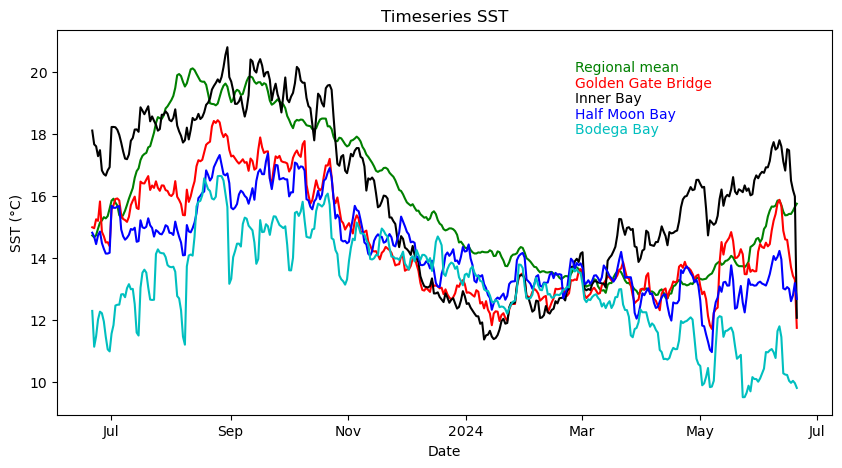

In [255]:
plt.figure(figsize=(10, 5))  # 10 inches wide, 6 inches tall
(ds2.analysed_sst-273.15).mean({'lat','lon'}).plot(color='g')
plt.text(ts.time[250].data,19.5+.5,'Regional mean',color = 'g')
for i in range(len(slon)):
    (ds2.analysed_sst.sel(lon=slon[i],lat=slat[i],method='nearest')-273.15).plot(color=cc[i])
    plt.text(ds2.time[250].data,19.5-i*.5,gtext[i],color = cc[i])
plt.title('Timeseries SST')
plt.ylabel('SST (°C)')
plt.xlabel('Date')

The figure above shows timeseries of SSTs around SF Bay. 
The regional mean (green line) has a nice annual cycle, warmest in August and coolest in April.
The points outside SF Bay are all cooler than the regional mean except from December to April when there isn't any upwelling. From April to November there is upwelling that cools the temperatures near the coast. To look at the magnitude of the coastal upwelling we can take the offshore temperature minus the near shore temperature, as we do in the next figure.

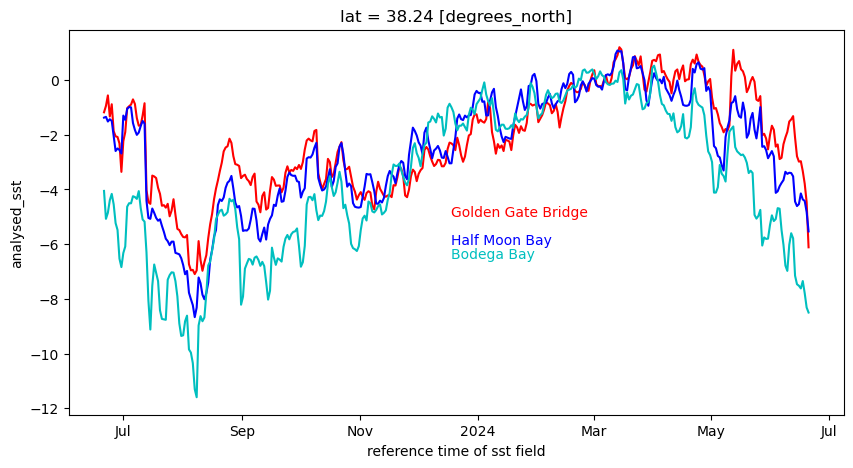

In [352]:
plt.figure(figsize=(10, 5))  # 10 inches wide, 6 inches tall
for i in range(len(slon)):
    if i==1:
        continue
    d1 = ds2.analysed_sst.sel(lon=slon[i],lat=slat[i],method='nearest')
    d2 = ds2.analysed_sst.sel(lon=slon[i]-10,lat=slat[i],method='nearest')
    dif = d1-d2
    dif.plot(color=cc[i])
    plt.text(ts.time[180].data,-5-i*.5,gtext[i],color = cc[i])

# check against buoy data
Station 46237 - San Francisco Bar, CA (142) Image indicating link to RSS feed of recent meteorological observations for station 46237
Information submitted by Scripps Institution of Oceanography
Waverider Buoy
37.788 N 122.634 W (37°47'16" N 122°38'1" W)



In [339]:
station = '46237'
blat,blon = 37.788,-122.634
df_buoy = get_buoy_data(station)

0 17311
1 18376
2 19767
3 21254
4 22649
5 24136
6 25575


16869


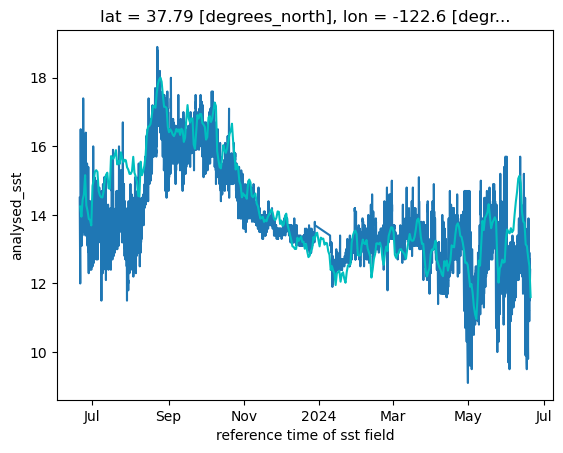

In [341]:
print(len(df_buoy))
plt.plot(df_buoy.time,df_buoy.WTMP)
(ds2.analysed_sst.sel(lon=blon,lat=blat,method='nearest')-273.15).plot(color=cc[i])